## This notebook separates the labeled training data into two parts, each with class labels, for rapid testing and evaluation. Reports evaluation metrics at the end of the notebook

In [55]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

# For producing decision tree diagrams.
from IPython.core.display import Image, display

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Set the randomizer seed so results are the same each time
np.random.seed(1)

In [56]:
# import training data from relative filepath
data = pd.read_csv("../../data/train.csv")

# shuffles the data by taking a random sample without replacement
# and sampling 100% of the original dataframe
data = data.sample(frac = 1)

print("The entire training set is " + str(len(data)) + " so, with 80% for training, there will " +
     "be " + str(len(data)*0.8) + " samples in training and " + str(len(data)*0.2) + " samples " +
     "in the test.")
data.head()

The entire training set is 15120 so, with 80% for training, there will be 12096.0 samples in training and 3024.0 samples in the test.


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
5765,5766,2489,333,18,124,39,458,176,214,176,...,0,0,0,0,0,0,0,0,0,6
11340,11341,2696,4,13,30,10,2800,202,214,148,...,0,0,0,0,0,0,0,0,0,1
9270,9271,3413,140,17,134,6,4271,243,233,113,...,0,0,0,0,0,0,0,0,0,7
5710,5711,2874,116,18,153,17,2379,248,220,94,...,0,0,0,0,0,0,0,0,0,5
1070,1071,3001,57,18,180,28,4673,229,200,97,...,0,0,0,0,0,0,0,0,0,1


In [57]:
# extract random sample of training data except labels and ID column
train_df = data.loc[:, (data.columns != "Cover_Type") & (data.columns != "Id")].iloc[:12096]

# extract labels from training data
train_labels_df = data.iloc[:12096].loc[:, "Cover_Type"]

train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
5765,2489,333,18,124,39,458,176,214,176,1409,...,0,0,0,0,0,0,0,0,0,0
11340,2696,4,13,30,10,2800,202,214,148,6524,...,0,0,0,0,0,0,0,0,0,0
9270,3413,140,17,134,6,4271,243,233,113,4272,...,0,0,0,0,0,0,0,0,0,0
5710,2874,116,18,153,17,2379,248,220,94,564,...,0,0,0,0,0,0,0,0,0,0
1070,3001,57,18,180,28,4673,229,200,97,1864,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# extract test data except ID and Cover_Type column
test_df = data.loc[:, (data.columns != "Cover_Type") & (data.columns != "Id")].iloc[12096:]

# extract labels data
test_labels_df = data.iloc[12096:].loc[:, "Cover_Type"]

test_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
3970,2058,9,5,0,0,646,215,230,153,811,...,0,0,0,0,0,0,0,0,0,0
6060,2444,295,16,85,6,1165,172,234,201,234,...,0,0,0,0,0,0,0,0,0,0
13589,2751,237,16,190,56,939,191,252,196,1926,...,0,0,0,0,0,0,0,0,0,0
10193,2850,53,18,134,53,2186,227,197,97,2254,...,0,0,1,0,0,0,0,0,0,0
10745,2835,104,6,95,16,2093,230,233,136,1239,...,0,0,0,0,0,0,0,0,0,0


In [68]:
## Create current best classifier

# build classifier
classifier = LogisticRegression(C=10, penalty = 'l1', solver="liblinear", multi_class="auto")

# fit classifier to training data
classifier.fit(train_df, train_labels_df)

# make predictions of test data
predictions = classifier.predict(test_df)


              precision    recall  f1-score   support

           1       0.63      0.67      0.65       418
           2       0.60      0.51      0.55       430
           3       0.60      0.52      0.55       476
           4       0.77      0.89      0.82       392
           5       0.67      0.69      0.68       483
           6       0.52      0.56      0.54       414
           7       0.89      0.88      0.88       411

    accuracy                           0.67      3024
   macro avg       0.67      0.67      0.67      3024
weighted avg       0.67      0.67      0.66      3024



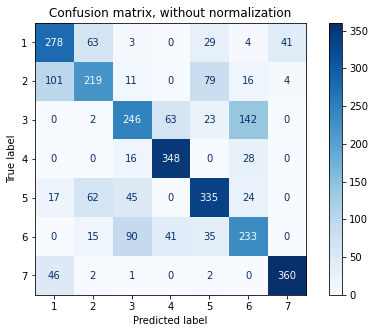

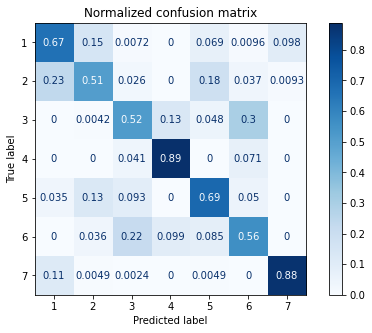

Overall accuracy: 66.77%


In [69]:
# generate and print classification report
print(classification_report(test_labels_df, predictions))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, test_df, test_labels_df,
                                 display_labels= [str(number) for number in range(1, 8)],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    fig = plt.gcf()
    fig.set_size_inches(8,5)

plt.show()

# calculate and print accuracy
print("Overall accuracy: " + 
      str(round(100*metrics.accuracy_score(test_labels_df, predictions),2)) + "%")

In [62]:
## Use grid search to evaluate parameters

# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
# logreg=LogisticRegression()
# logreg_cv=GridSearchCV(logreg,grid,cv=10)
# logreg_cv.fit(train_df,train_labels_df)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

# choose variables for grid search
parameters={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

# build classifier
classifier = GridSearchCV(LogisticRegression(penalty='l2'), 
                          param_grid = parameters, cv = 10,  
                          scoring = "accuracy")

# fit classifier to training data
classifier.fit(train_df, train_labels_df)

# make predictions of test data
predictions = classifier.predict(test_df)

In [63]:
print("Best parameters = ", classifier.best_params_)

# calculate and print accuracy
print("Overall accuracy: " + 
      str(round(100*metrics.accuracy_score(test_labels_df, predictions),2)) + "%")

Best parameters =  {'C': 1.0, 'penalty': 'l2'}
Overall accuracy: 46.59%


In [64]:
## Use manual loop to evaluate parameters

parameters={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

for p in parameters['penalty']:
    for c in parameters['C']:
    
        # build classifier
        classifier = LogisticRegression(C = c, penalty = p, solver="liblinear", multi_class="auto")

        # fit classifier to training data
        classifier.fit(train_df, train_labels_df)

        # make predictions of test data
        predictions = classifier.predict(test_df)

        print("Penalty:",p," IRS:%.4f"%c)
        # calculate and print accuracy
        print("Accuracy: " + 
          str(round(100*metrics.accuracy_score(test_labels_df, predictions),2)) + "%")

Penalty: l1  IRS:0.0010
Accuracy: 55.89%
Penalty: l1  IRS:0.0100
Accuracy: 61.01%
Penalty: l1  IRS:0.1000
Accuracy: 65.84%
Penalty: l1  IRS:1.0000
Accuracy: 66.63%
Penalty: l1  IRS:10.0000
Accuracy: 66.77%
Penalty: l1  IRS:100.0000
Accuracy: 66.63%
Penalty: l1  IRS:1000.0000
Accuracy: 66.63%
Penalty: l2  IRS:0.0010
Accuracy: 59.59%
Penalty: l2  IRS:0.0100
Accuracy: 63.99%
Penalty: l2  IRS:0.1000
Accuracy: 66.04%
Penalty: l2  IRS:1.0000
Accuracy: 65.24%
Penalty: l2  IRS:10.0000
Accuracy: 65.15%
Penalty: l2  IRS:100.0000
Accuracy: 66.1%
Penalty: l2  IRS:1000.0000
Accuracy: 66.5%
